In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np

In [2]:
class BlackjackAgent:

    def __init__(self,
                 env: gym.Env,
                 learning_rate: float,
                 initial_epsilon:float,
                 epsilon_decay: float,
                 final_epsilon: float,
                 discount_factor: float = 0.95):
        
        """
        Initialize a Q-learning agent here.

        Inputs:
        1. env: The gymnasium training environment
        2. learning_rate: how quickly to update Q-values, similar to gradient descent algorithms
        3. initial_epsilon: initial rate of exploration (for using epsilon-greedy methods)
        4. epsilon_deacy: the rate of deacy of the initial epsilon value: need to eventually start exploiting after exploration
        5. final_epsilon: final rate of exploration
        6. discount_factor: used to compute future rewards: a lower discount factor is extremely myopic view
        """

        # declare the training environment
        self.env = env

        # Define the Q-value table: maps (state, action) --> expected reward (return)
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate # learning rate
        self.df = discount_factor # discount factor

        self.eps = initial_epsilon
        self.epsdecy = epsilon_decay
        self.epsfin = final_epsilon

        self.training_error = []

    """
    Write a function to implement the epsilon-greedy strategy
    Inputs:
    obs:
    """
    def choose_action(self, obs: tuple[int, int, bool]) -> int:

        if np.random.random() < self.eps:
            return self.env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Update Q-value based on experience.

        This is the heart of Q-learning: learn from (state, action, reward, next_state)
        """

        # current q value of the current (state, action)
        current_q = self.q_values[obs][action]

        # by taking this (action) at this (state)[obs] you reached (next_state)[next_obs]
        
        # What's the best we could do from the next state? take max of all possible actions
        # (Zero if episode terminated - no future rewards possible)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        # What should the Q-value be? (Bellman equation)
        target = reward + self.df * future_q_value

        # How wrong was our current estimate?
        temporal_difference = target - self.q_values[obs][action]

        # Update our estimate in the direction of the error
        # Learning rate controls how big steps we take
        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        # Track learning progress (useful for debugging)
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """Reduce exploration rate after each episode."""
        self.eps = max(self.epsfin, self.eps - self.epsdecy)

#### Understanding how ```defaultdict``` works

In [3]:
a = defaultdict(lambda: np.zeros(5))

Now, run the following cell, and then observe what changes happen to ```a```

In [4]:
a[1]

array([0., 0., 0., 0., 0.])

In [5]:
# run this cell to see what has changed in a
a

defaultdict(<function __main__.<lambda>()>, {1: array([0., 0., 0., 0., 0.])})

In [6]:
# run this to see what happens to a again
a[3]

array([0., 0., 0., 0., 0.])

In [7]:
# I think by now you have understood
a

defaultdict(<function __main__.<lambda>()>,
            {1: array([0., 0., 0., 0., 0.]), 3: array([0., 0., 0., 0., 0.])})

# Train the Agent now

In [8]:
# Training hyperparameters
learning_rate = 0.01        # How fast to learn (higher = faster but less stable)
n_episodes = 100_000        # Number of hands to practice
start_epsilon = 1.0         # Start with 100% random actions
epsilon_decay = start_epsilon / (n_episodes / 2)  # Reduce exploration over time
final_epsilon = 0.1         # Always keep some exploration

# Create environment and agent
env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [9]:
from tqdm import tqdm  # Progress bar

for episode in tqdm(range(n_episodes)):

    # Start a new hand
    obs, info = env.reset() # get the first observation and some debug information from the environment
    done = False

    # Play one complete hand
    while not done:
        # Agent chooses action (initially random, gradually more intelligent)
        action = agent.choose_action(obs)

        # Take action and observe result
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Learn from this experience
        agent.update(obs, action, reward, terminated, next_obs)

        # Move to next state
        done = terminated or truncated # terminated becomes true if terminal state (according to Blackhack rules) is reached, truncated when number of steps exceed
        obs = next_obs

    # Reduce exploration rate (agent becomes less random over time)
    agent.decay_epsilon()


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [00:05<00:00, 19216.05it/s]


# Visualize

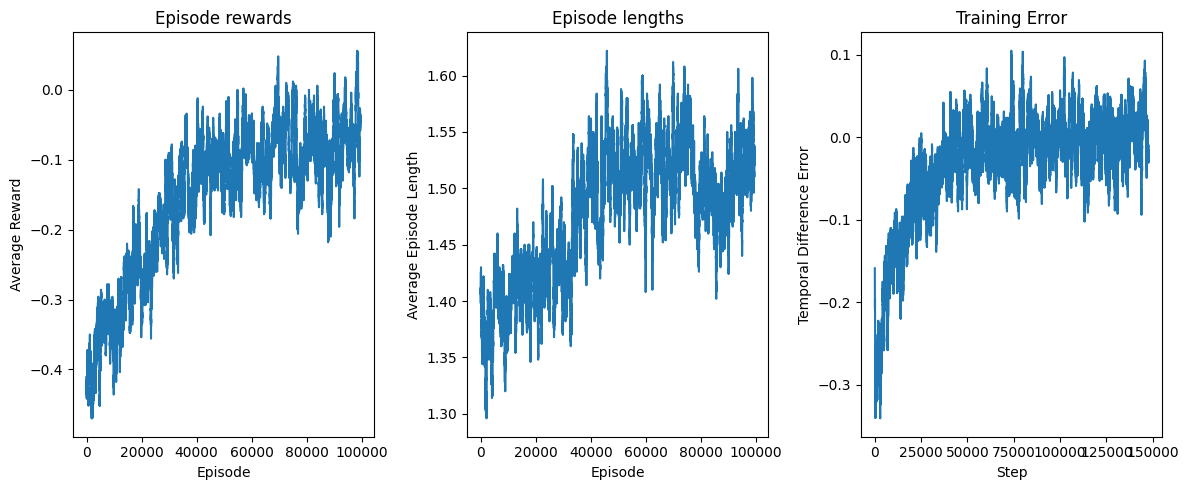

In [10]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error")
training_error_moving_average = get_moving_avgs(
    agent.training_error,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.show()

In [13]:
# Test the trained agent
def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    # Temporarily disable exploration for testing
    old_epsilon = agent.eps
    agent.eps = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.choose_action(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_rewards.append(episode_reward)

    # Restore original epsilon
    agent.epsilon = old_epsilon

    win_rate = np.mean(np.array(total_rewards) > 0)
    average_reward = np.mean(total_rewards)

    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average Reward: {average_reward:.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")

# Test your agent
test_agent(agent, env)

Test Results over 1000 episodes:
Win Rate: 42.8%
Average Reward: -0.051
Standard Deviation: 0.951
